### Introduction

#### Importing necessary libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import glob
import os

from pylab import *
from PIL import Image 
import cv2 as cv

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Getting local directory and load image data

In [2]:
#Get current working directory
cwd = os.getcwd()

path = cwd[:-9] + "\\Images"                     
all_files = glob.glob(os.path.join(path, "*.png")) # OS independent
all_files.sort(key=os.path.getmtime) #sort by time created to get the same order of results

#### Get labels (climate zone) from file names

In [3]:
y = np.empty((len(all_files), 1))

for i in range(0, len(all_files)):
    y[i] = all_files[i].split('\\')[-1].split('_')[-2]

#### Crop, rescale and grayscale images; save resulting images in a numpy array

In [4]:
##First 456 pictures have different boundaries, so we crop them here separately

#Initial dimensions of the images, after cropping: in this case 745 x 745
init_height, init_width = 745, 745
#Target dimension, change this to the dimension you want
target_height, target_width = 80, 80
#Resize factors
fx, fy = (target_height / init_height), (target_width / init_width)
#Create an array to save arrays of images
Results_a = np.empty((456, target_height, target_width))

for i in range(0, 456):
    im = Image.open(all_files[i])
    im = im.crop((25,25,770,770))
    im = im.convert('L')
    im_resized = cv.resize(np.array(im), None, fx=fx, fy=fy, interpolation = cv.INTER_AREA)
    im_resized = im_resized / 255
    Results_a[i] = im_resized

In [5]:
##This is for the rest of the pictures

#Initial dimensions of the images, after cropping: in this case 610 x 610
init_height2, init_width2 = 610, 610
#Resize factors
fx2, fy2 = (target_height / init_height2), (target_width / init_width2)
#Create an array to save arrays of images
Results_b = np.empty((4728, target_height, target_width))

for i in range(4728):
    im = Image.open(all_files[i+456])
    im = im.crop((90, 90,700,700))
    im = im.convert('L')
    im_resized = cv.resize(np.array(im), None, fx=fx2, fy=fy2, interpolation = cv.INTER_AREA)
    im_resized = im_resized / 255
    Results_b[i] = im_resized

In [6]:
#Merge both result arrays
Results = np.vstack((Results_a, Results_b))
print('Result shape is:', Results.shape)

#Generate train and test sets
import random
a = random.sample(range(0, len(Results)), int(len(Results)*0.2))
np.random.shuffle(a)
mask = np.ones(len(Results), dtype=bool)
mask[a] = False

X_train = Results[mask].reshape(-1,target_height*target_width, 1)
X_test = Results[a].reshape(-1,target_height*target_width, 1)

y_train = y[mask]
y_train = to_categorical(y_train, 3)
y_test = y[a]
y_test = to_categorical(y_test, 3)
y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)
print('Training set shape is:', X_train.shape)
print('Testing set shape is:', X_test.shape)
print('Total number of rows are:', (len(X_train)+len(X_test)))
print(y_train.shape)
print(y_test.shape)

Result shape is: (5184, 80, 80)
Training set shape is: (4148, 6400, 1)
Testing set shape is: (1036, 6400, 1)
Total number of rows are: 5184
(4148, 3, 1)
(1036, 3, 1)


#### Create the ZCA Whitening matrix (optional to test)

https://martin-thoma.com/zca-whitening/

https://en.wikipedia.org/wiki/Whitening_transformation

In [ ]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

#### Create the Temporal Convolutional Network (TCN) model

https://arxiv.org/abs/1608.08242

https://github.com/philipperemy/keras-tcn

In [7]:
from tcn import tcn

model = tcn.dilated_tcn(output_slice_index='last',
                        num_feat=1,
                        num_classes=3,
                        nb_filters=64,
                        kernel_size=8,
                        dilatations=[1, 2, 4, 8],
                        nb_stacks=8,
                        max_len=X_train.shape[1],
                        activation='norm_relu')

C:\Users\user\Anaconda3\lib\site-packages\keras\legacy\layers.py:741: UserWarning: The `AtrousConvolution1D` layer  has been deprecated. Use instead the `Conv1D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution1D` layer '
C:\Users\user\Anaconda3\lib\site-packages\tcn\tcn.py:38: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  res_x = Merge(mode='sum')([original_x, x])


x.shape= (?, 64)
model.x = (?, 6400, 1)
model.y = (?, 3)
Adam with norm clipping.


C:\Users\user\Anaconda3\lib\site-packages\tcn\tcn.py:62: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  x = Merge(mode='sum')(skip_connections)


#### Train the model on the train data

In [8]:
model.fit(X_train, y_train.squeeze().argmax(axis=1), epochs=3, batch_size=5,
          validation_data=(X_test, y_test.squeeze().argmax(axis=1)), verbose=2)

Train on 4148 samples, validate on 1036 samples
Epoch 1/3
 - 350s - loss: 0.1686 - acc: 0.9407 - val_loss: 0.0044 - val_acc: 0.9981
Epoch 2/3
 - 342s - loss: 0.0484 - acc: 0.9923 - val_loss: 2.8347e-06 - val_acc: 1.0000
Epoch 3/3
 - 341s - loss: 0.0477 - acc: 0.9920 - val_loss: 1.5212e-05 - val_acc: 1.0000


#### Predict labels and evaluate model performance

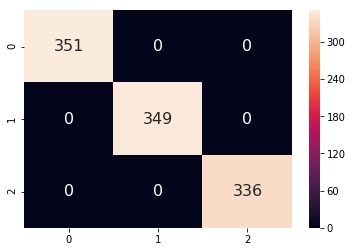

In [9]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.squeeze().argmax(axis=1), y_pred.squeeze().argmax(axis=1))

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()